In [1]:
# Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Warnings
import warnings
warnings.filterwarnings('ignore')



In [19]:
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import wordcloud

import nltk
nltk.download()
import string
from nltk.tokenize import word_tokenize

import spacy
nlp = spacy.load("en")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 


showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


# Data Analysis

In [20]:
data = pd.read_csv("spam.csv",encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [21]:
data = data.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
data.columns = ["label", "text"]


In [22]:
data.describe()

,label,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


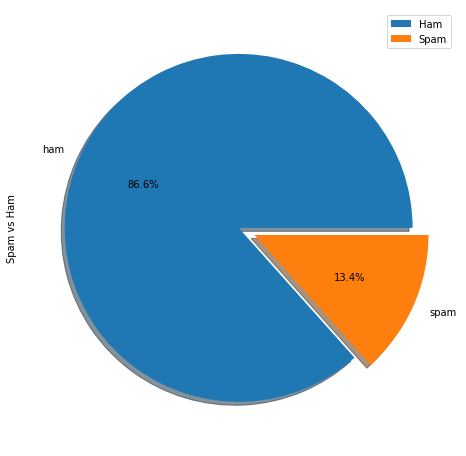

In [23]:
data["label"].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (8, 8), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()




A lot of messages are actually not spam. About 86% of our dataset consists of normal messages.

- While we split our data set into train and test or when we use cross validation, we will have to use stratified sampling, otherwise we have a chance of our training model being skewed towards normal messages. If the sample we choose to train our model consists majorly of normal messages, it may end up predicting everything as ham and we might not be able to figure this out since most of the messages we get are actually ham and will have a pretty good accuracy.

- A very basic model would be a model that predicts everything as ham. It would have a decent accuracy. But then again, is that right? No. We will then have to use an accuracy metric that keeps this in mind. Goal : We don't mind if we miss the odd spam message but we surely don't want to mark a ham message as spam i.e Precision is very important. Hence we will use fbeta score as our accuracy metric with inclination towards Precision



#### 1.1 Add numerical label for spam

Target must be numerical for ML classification mode

In [24]:
data['spam'] = data['label'].map( {'spam': 1, 'ham': 0} ).astype(int)
data.head(7)

,label,text,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1
6,ham,Even my brother is not like to speak with me. ...,0


#### 1.2 length of message

In [25]:
data['length'] = data['text'].apply(len)
data.head(5)


,label,text,spam,length
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


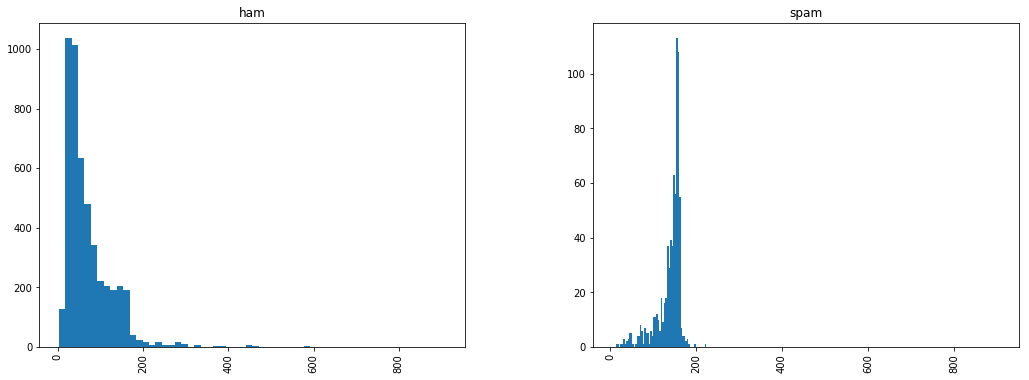

In [26]:
data.hist(column='length',by='label',bins=60,figsize=(17,6));
plt.xlim(-40,950);                                                        

Looks like spam messages are generally longer than ham messages;

In [27]:
data_ham  = data[data['spam'] == 0].copy()
data_spam = data[data['spam'] == 1].copy()


#### 1.3 WordClouds

In [28]:
def show_wordcloud(data, title):
    text = ' '.join(data['text'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='lightgrey',
                    colormap='viridis', width=800, height=600).generate(text)
    
    plt.figure(figsize=(15,12), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20 )
    plt.show()



**Word Cloud of Ham Messages**

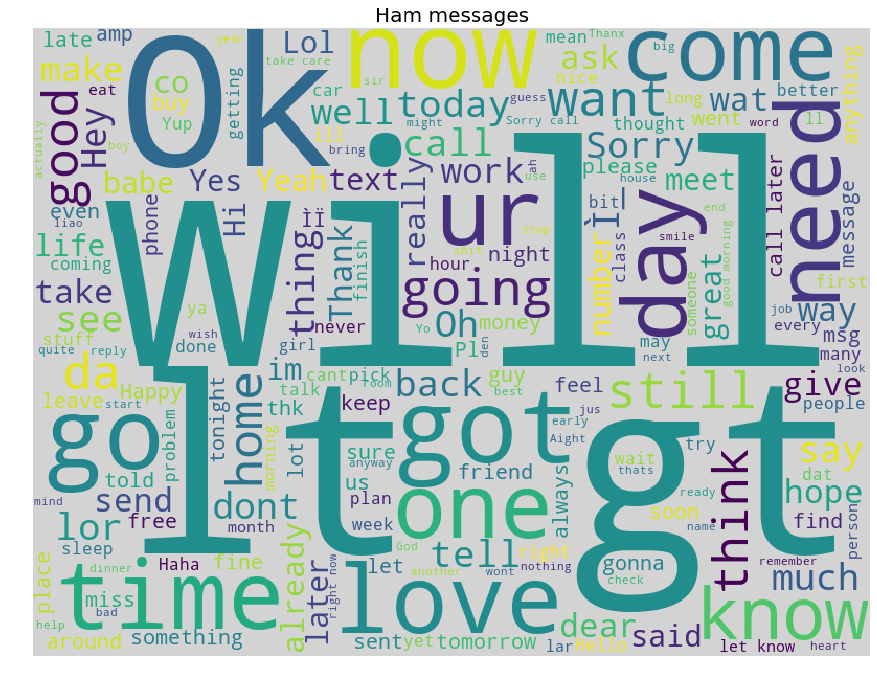

In [29]:
show_wordcloud(data_ham, "Ham messages")

**Word Cloud of Spam Messages**

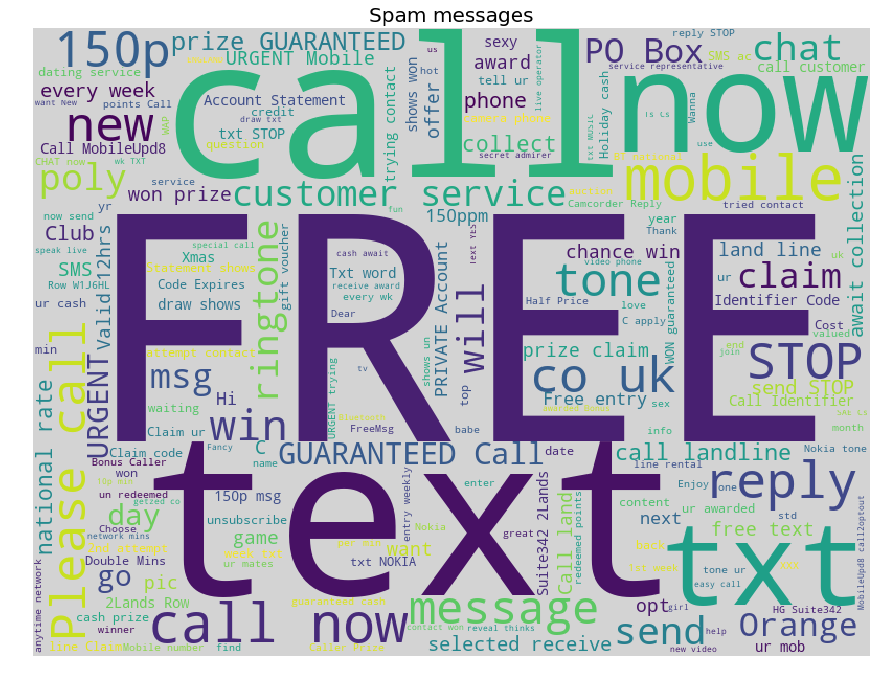

In [30]:
show_wordcloud(data_spam, "Spam messages")

In [31]:
topMessages = data.groupby("text")["label"].agg([len, np.max]).sort_values(by = "len", ascending = False).head(n = 10)
display(topMessages)

,len,amax
text,,
"Sorry, I'll call later",30,ham
I cant pick the phone right now. Pls send a message,12,ham
Ok...,10,ham
Your opinion about me? 1. Over 2. Jada 3. Kusruthi 4. Lovable 5. Silent 6. Spl character 7. Not matured 8. Stylish 9. Simple Pls reply..,4,ham
"Wen ur lovable bcums angry wid u, dnt take it seriously.. Coz being angry is d most childish n true way of showing deep affection, care n luv!.. kettoda manda... Have nice day da.",4,ham
Please call our customer service representative on FREEPHONE 0808 145 4742 between 9am-11pm as you have WON a guaranteed å£1000 cash or å£5000 prize!,4,spam
Okie,4,ham
"Say this slowly.? GOD,I LOVE YOU &amp; I NEED YOU,CLEAN MY HEART WITH YOUR BLOOD.Send this to Ten special people &amp; u c miracle tomorrow, do it,pls,pls do it...",4,ham
"7 wonders in My WORLD 7th You 6th Ur style 5th Ur smile 4th Ur Personality 3rd Ur Nature 2nd Ur SMS and 1st \Ur Lovely Friendship\""... good morning dear""",4,ham


# Text Transformation

Cleaning our data by:
- removing punctuations
- stopwords and 
- stemming words

### Snowball is a small string processing language designed for creating stemming algorithms for use in Information Retrieval. 

In [15]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english")

def cleanText(data):
    
    data = data.translate(str.maketrans('', '', string.punctuation))
    words = [stemmer.stem(word) for word in data.split() if word.lower() not in stopwords.words("english")]
    
    return " ".join(words)

data["text"] = data["text"].apply(cleanText)
data.head(n = 10)    


,label,text,spam,length
0,ham,go jurong point crazi avail bugi n great world...,0,111
1,ham,ok lar joke wif u oni,0,29
2,spam,free entri 2 wkli comp win fa cup final tkts 2...,1,155
3,ham,u dun say earli hor u c alreadi say,0,49
4,ham,nah dont think goe usf live around though,0,61
5,spam,freemsg hey darl 3 week word back id like fun ...,1,148
6,ham,even brother like speak treat like aid patent,0,77
7,ham,per request mell mell oru minnaminungint nurun...,0,160
8,spam,winner valu network custom select receivea å£9...,1,158
9,spam,mobil 11 month u r entitl updat latest colour ...,1,154


#### Lets convert our clean text into a representation that a machine learning model can understand.

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(encoding = "latin-1", strip_accents = "unicode", stop_words = "english")
features = vec.fit_transform(data["text"])
print(features.shape)

(5572, 7903)


# Model Aplication

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, data["spam"], stratify = data["spam"], test_size = 0.2)

In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score

from sklearn.naive_bayes import MultinomialNB
gaussianNb = MultinomialNB()
gaussianNb.fit(X_train, y_train)

y_pred = gaussianNb.predict(X_test)

print(fbeta_score(y_test, y_pred, beta = 0.5))


0.933786078098472
